# Multi-label Disease Classification of Chest X-Ray Images

UC San Diego Machine Learning Engineering Bootcamp

Tung Nguyen

## Introduction

Dataset: NIH Chest X-Rays from Kaggle, https://www.kaggle.com/nih-chest-xrays/data

This notebook contains the best performing models from Rounds 1 - 4 of tuning, trained on the full dataset.

## Imports
---

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_Xc

from tensorflow.keras.applications import DenseNet169, DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_dn

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import roc_curve, auc, precision_recall_curve, multilabel_confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_state = 2022

train_size = 0.8
val_size = 0.2
test_size = 0.25

In [3]:
data_dir = '/Users/tungnguyen/Documents/repos/capstone-data/data/'

## Data Preprocessing
---

### Wrangling

In [4]:
# Read CSV
df = pd.read_csv('/Users/tungnguyen/Documents/repos/capstone-data/Data_Entry_2017.csv')

# Drop unnecessary columns
df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=True)
print('Original DataFrame shape = {}'.format(df.shape))

# Some patients have age >200 - impute with mean of age from rows with the same Patient ID
err = df[df['Patient Age'] > 100]
df_dropped = df[df['Patient Age'] < 100]

for ind, row in err.iterrows():
    pid = row['Patient ID']
    avg = df_dropped[df_dropped['Patient ID'] == pid]['Patient Age'].mean()
    df.iat[ind, 4] = int(avg) if not(np.isnan(avg)) else -1

# There are ~3 patients with just a single datapoint - drop these 3 data points
df = df[df['Patient Age'] != -1]
df.reset_index(inplace=True)
print('Wrangled DataFrame shape = {}'.format(df.shape))

# Replace "No Finding" labels with blank
df['Finding Labels'] = df['Finding Labels'].replace(to_replace='No Finding', value='')

# Binarize
mlb = MultiLabelBinarizer()
lbl = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_mlb = pd.DataFrame(lbl, columns=mlb.classes_, dtype=np.float32)

# Drop 'No Finding' column
df_mlb.drop('', axis=1, inplace=True)

# Merge with main df
df = df.join(df_mlb)
print('Binarized DataFrame shape = {}'.format(df.shape))

# Get list of all labels
labels = [x for x in mlb.classes_ if x != '']
print()
print(labels)

Original DataFrame shape = (112120, 7)
Wrangled DataFrame shape = (112117, 8)
Binarized DataFrame shape = (112117, 22)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


### Splitting

In [5]:
tab_data_cols = ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']
X = df[tab_data_cols]
y = df[labels]

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X.to_numpy(), 
    y.to_numpy(), 
    test_size=test_size,
)

In [6]:
# Convert matrices to DataFrames for Keras' flow_from_dataframe
train_df = pd.DataFrame(
    np.hstack((X_train, y_train)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

test_df = pd.DataFrame(
    np.hstack((X_test, y_test)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

# Convert labels to float32 for Keras training
for col in train_df:
    if col in labels:
        train_df[col] = train_df[col].astype(np.float32)
        
for col in test_df:
    if col in labels:
        test_df[col] = test_df[col].astype(np.float32)

In [7]:
# Traditional train test split - for comparison purposes
from sklearn.model_selection import train_test_split

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=test_size)
train_df_2 = pd.concat([X_train_2, y_train_2], axis=1)

### Sampling

In [8]:
plt.style.use('tableau-colorblind10')

In [9]:
def plot_df_freq(df, labels, offset=500, title='Frequency of Positive Labels'):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');

    for i, val in enumerate(df_pos.values):
        ax.text(i, val + offset, int(val), ha = 'center')
        
    return df_pos

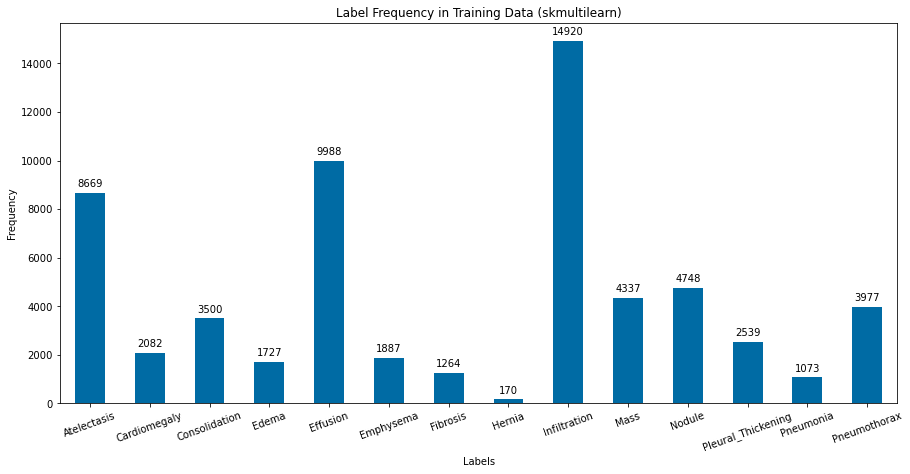

In [10]:
df_freq = plot_df_freq(train_df, labels, offset=250, title='Label Frequency in Training Data (skmultilearn)')

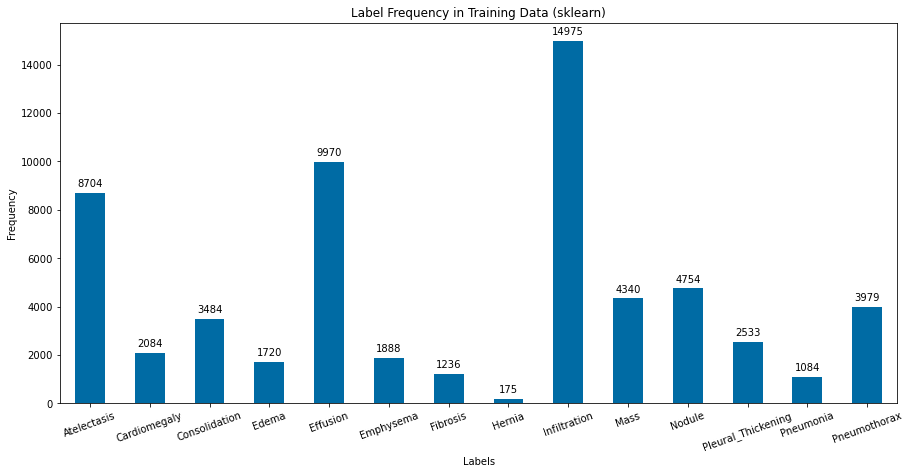

In [11]:
df_freq_2 = plot_df_freq(train_df_2, labels, offset=250, title='Label Frequency in Training Data (sklearn)')

In [12]:
train_df

Image Index          Finding Labels Follow-up # Patient ID  \
0      00000001_000.png            Cardiomegaly           0          1   
1      00000001_001.png  Cardiomegaly|Emphysema           1          1   
2      00000002_000.png                                   0          2   
3      00000003_001.png                  Hernia           1          3   
4      00000003_003.png     Hernia|Infiltration           3          3   
...                 ...                     ...         ...        ...   
84082  00030798_000.png                                   0      30798   
84083  00030799_000.png                                   0      30799   
84084  00030801_001.png          Mass|Pneumonia           1      30801   
84085  00030803_000.png                                   0      30803   
84086  00030805_000.png                                   0      30805   

      Patient Age Patient Gender View Position  Atelectasis  Cardiomegaly  \
0              58              M            PA          0.0           1.0   
1              58              M            PA          0.0           1.0   
2              81              M            PA          0.0           0.0   
3              74              F            PA          0.0           0.0   
4              76              F            PA          0.0           0.0   
...           ...            ...           ...          ...           ...   
84082          30              M            PA          0.0           0.0   
84083          32              M            PA          0.0           0.0   
84084          39              M            PA          0.0           0.0   
84085          42              F            PA          0.0           0.0   
84086          27              M            PA          0.0           0.0   

       Consolidation  ...  Effusion  Emphysema  Fibrosis  Hernia  \
0                0.0  ...       0.0        0.0       0.0     0.0   
1                0.0  ...       0.0        1.0       0.0     0.0   
2                0.0  ...       0.0        0.0       0.0     0.0   
3                0.0  ...       0.0        0.0       0.0     1.0   
4                0.0  ...       0.0        0.0       0.0     1.0   
...              ...  ...       ...        ...       ...     ...   
84082            0.0  ...       0.0        0.0       0.0     0.0   
84083            0.0  ...       0.0        0.0       0.0     0.0   
84084            0.0  ...       0.0        0.0       0.0     0.0   
84085            0.0  ...       0.0        0.0       0.0     0.0   
84086            0.0  ...       0.0        0.0       0.0     0.0   

       Infiltration  Mass  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
0               0.0   0.0     0.0                 0.0        0.0           0.0  
1               0.0   0.0     0.0                 0.0        0.0           0.0  
2               0.0   0.0     0.0                 0.0        0.0           0.0  
3               0.0   0.0     0.0                 0.0        0.0           0.0  
4               1.0   0.0     0.0                 0.0        0.0           0.0  
...             ...   ...     ...                 ...        ...           ...  
84082           0.0   0.0     0.0                 0.0        0.0           0.0  
84083           0.0   0.0     0.0                 0.0        0.0           0.0  
84084           0.0   1.0     0.0                 0.0        1.0           0.0  
84085           0.0   0.0     0.0                 0.0        0.0           0.0  
84086           0.0   0.0     0.0                 0.0        0.0           0.0  

[84087 rows x 21 columns]

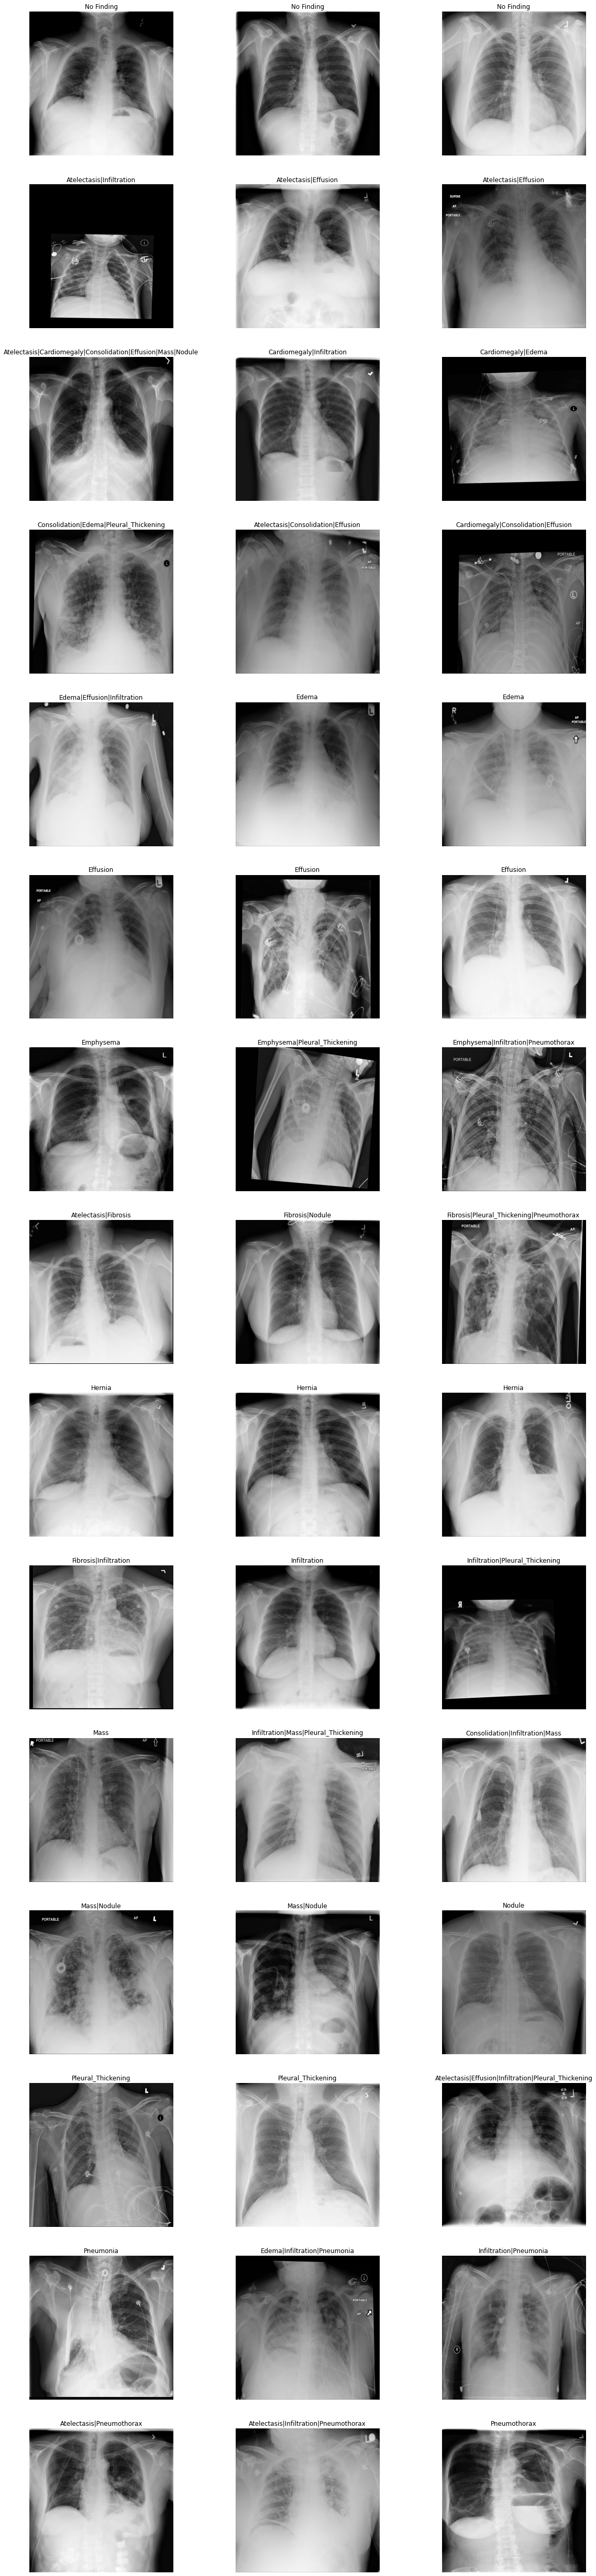

In [13]:
# Plot some sample images of Chest X-Rays from train_df
import matplotlib.image as img

fig, ax = plt.subplots(15, 3, figsize=(20, 90))

for c in np.arange(0, 3):
    img_path, true_label = train_df[train_df['Finding Labels'] == ''].sample(1, random_state=random_state + c)[['Image Index', 'Finding Labels']].T.values
    ex = img.imread(data_dir + img_path[0])
    ax[0, c].imshow(ex, cmap='gray')
    ax[0, c].set_title('No Finding')
    ax[0, c].axis('off')

    for r, lbl in enumerate(labels):
        img_path, true_label = train_df[train_df[lbl] == 1].sample(1, random_state=random_state + c)[['Image Index', 'Finding Labels']].T.values
        ex = img.imread(data_dir + img_path[0])
        ax[r+1, c].imshow(ex, cmap='gray')
        ax[r+1, c].set_title(true_label[0])
        ax[r+1, c].axis('off')

### Helper Functions

In [14]:
def plot_roc_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % (lbl, auc(fpr, tpr)))
        print("AUC = %0.4f for %s" % (auc(fpr, tpr), lbl))

    ax.legend()
    ax.set_title('ROC Curves for Test Data - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');

def plot_precision_recall_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(rc, pr, label = '%s (AUC: %0.4f)'  % (lbl, auc(rc, pr)))
        print("AUC = %0.4f for %s" % (auc(rc, pr), lbl))

    ax.legend()
    ax.set_title('Precision-Recall Curves for Test Data - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');

In [15]:
def datagen_from_df(train_df, test_df, x_col, y_cols, data_path, preproc_func=None,
                    target_size=(256, 256), val_split=0.2, batch_size=64, sample_size=1000, color_mode='rgb', 
                    sample_center=False, sample_std=False, feature_center=False, feature_std=False, rescale_factor=None, 
                    weight_col=None, random_state=2022):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        validation_split=val_split,
        samplewise_center=sample_center,
        samplewise_std_normalization=sample_std,
        featurewise_center=feature_center,
        featurewise_std_normalization=feature_std,
        rescale=rescale_factor,
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.1, 
        rotation_range=5, 
        shear_range = 0.1,
        fill_mode = 'reflect',
        zoom_range=0.15,
    )

    if feature_center or feature_std:
        raw_train_generator = ImageDataGenerator().flow_from_dataframe(
            train_df,   
            data_path,
            shuffle=True,
            batch_size=sample_size,
            class_mode='raw',
            color_mode=color_mode,
            target_size=target_size,
            x_col=x_col,
            y_col=y_cols,
            seed=random_state
        )

        first_batch = raw_train_generator.next()
        data_sample = first_batch[0]
        datagen.fit(data_sample, augment=False, rounds=1, seed=random_state)

    train_generator = datagen.flow_from_dataframe(
        train_df,   
        data_path,
        shuffle=True,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        weight_col=weight_col,
        subset='training',
        seed=random_state
    )

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation',
        seed=random_state
    )

    test_generator = datagen.flow_from_dataframe(
        test_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        seed=random_state
    )
    
    return train_generator, validation_generator, test_generator

## Scaled DL Prototype
---

### DataGenerators

In [16]:
train_generator_Xc, valid_generator_Xc, test_generator_Xc = datagen_from_df(
    train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input_Xc,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 67270 validated image filenames.
Found 16817 validated image filenames.
Found 28030 validated image filenames.


In [17]:
train_generator_dn, valid_generator_dn, test_generator_dn = datagen_from_df(
    train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input_dn,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 67270 validated image filenames.
Found 16817 validated image filenames.
Found 28030 validated image filenames.


### Model 11: Xception (Scaled)

In [18]:
# Base Model
base_model_Xc = Xception(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer = Dense(len(labels), activation='sigmoid')(base_model_Xc.output)
model_Xc = Model(base_model_Xc.input, output_layer)

for layer in model_Xc.layers:
    layer.trainable = True

model_Xc.load_weights(r'/Users/tungnguyen/Documents/repos/mec-capstone/Scaled_Prototype/Xception-model-11-scaled.h5')

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-03-08 19:11:29.329271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-08 19:11:29.329690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
y_pred_Xc = model_Xc.predict(test_generator_Xc, batch_size=64, verbose=True)

2022-03-08 19:11:31.233472: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-08 19:11:31.392687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 469s 1s/step


AUC = 0.7968 for Atelectasis
AUC = 0.9146 for Cardiomegaly
AUC = 0.7737 for Consolidation
AUC = 0.8822 for Edema
AUC = 0.8584 for Effusion
AUC = 0.9137 for Emphysema
AUC = 0.7822 for Fibrosis
AUC = 0.8440 for Hernia
AUC = 0.6130 for Infiltration
AUC = 0.8462 for Mass
AUC = 0.7441 for Nodule
AUC = 0.7695 for Pleural_Thickening
AUC = 0.7080 for Pneumonia
AUC = 0.8699 for Pneumothorax


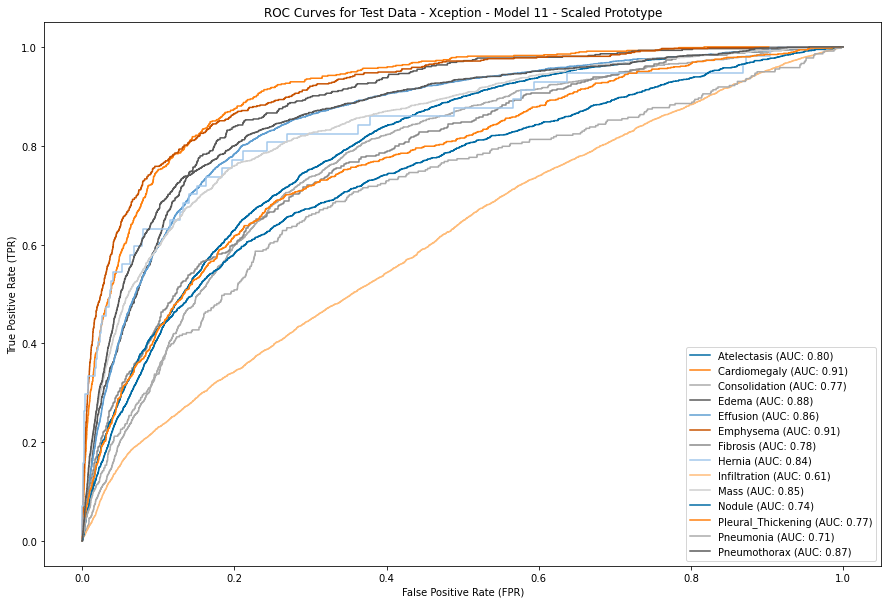

In [20]:
plot_roc_auc(y_pred_Xc, test_df, labels, model_name='Xception - Model 11 - Scaled Prototype')

AUC = 0.3083 for Atelectasis
AUC = 0.2959 for Cardiomegaly
AUC = 0.1171 for Consolidation
AUC = 0.1400 for Edema
AUC = 0.4682 for Effusion
AUC = 0.3426 for Emphysema
AUC = 0.0716 for Fibrosis
AUC = 0.0749 for Hernia
AUC = 0.2696 for Infiltration
AUC = 0.2956 for Mass
AUC = 0.1880 for Nodule
AUC = 0.1259 for Pleural_Thickening
AUC = 0.0430 for Pneumonia
AUC = 0.3033 for Pneumothorax


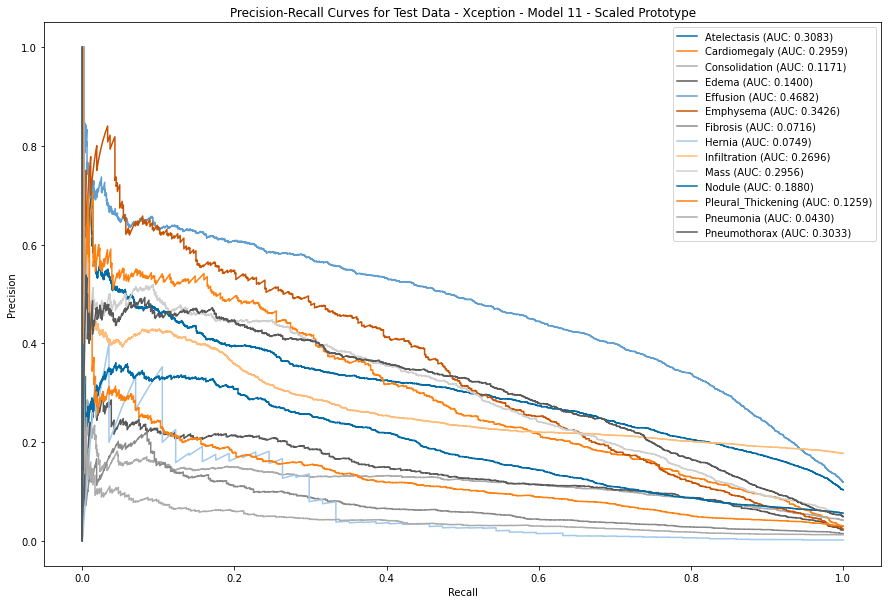

In [21]:
plot_precision_recall_auc(y_pred_Xc, test_df, labels, model_name='Xception - Model 11 - Scaled Prototype')

### Model 13.1: DenseNet169 (Scaled)

In [22]:
base_model_dn169 = DenseNet169(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer = Dense(len(labels), activation='sigmoid')(base_model_dn169.output)
model_dense169 = Model(base_model_dn169.input, output_layer)

for layer in model_dense169.layers:
    layer.trainable = True

model_dense169.load_weights(r'/Users/tungnguyen/Documents/repos/mec-capstone/Scaled_Prototype/DenseNet169-model-13-1-scaled.h5')

In [23]:
y_pred_dn = model_dense169.predict(test_generator_dn, batch_size=64, verbose=True)

2022-03-08 19:19:24.911856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 471s 1s/step


AUC = 0.7823 for Atelectasis
AUC = 0.9121 for Cardiomegaly
AUC = 0.7813 for Consolidation
AUC = 0.8831 for Edema
AUC = 0.8530 for Effusion
AUC = 0.8977 for Emphysema
AUC = 0.7676 for Fibrosis
AUC = 0.9134 for Hernia
AUC = 0.6495 for Infiltration
AUC = 0.8522 for Mass
AUC = 0.7141 for Nodule
AUC = 0.7539 for Pleural_Thickening
AUC = 0.7170 for Pneumonia
AUC = 0.8504 for Pneumothorax


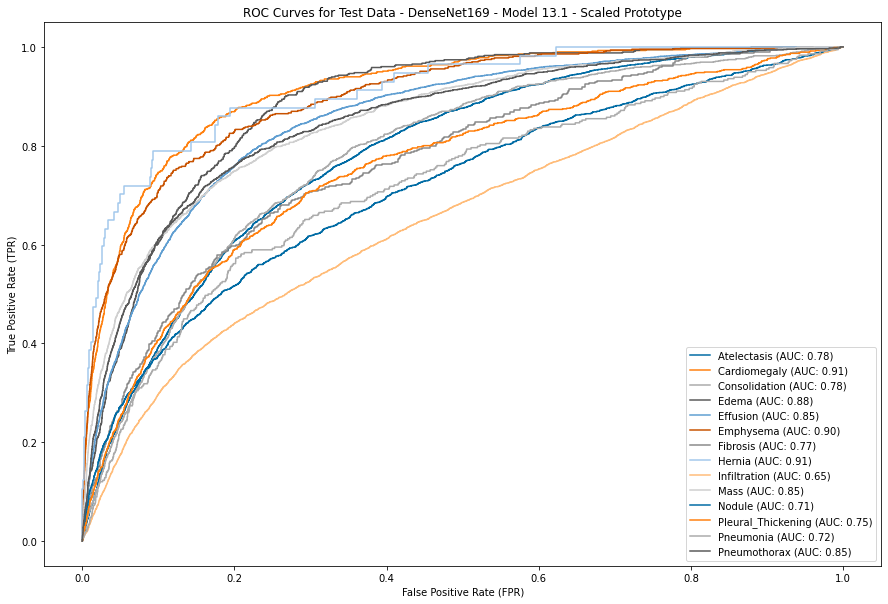

In [24]:
plot_roc_auc(y_pred_dn, test_df, labels, model_name='DenseNet169 - Model 13.1 - Scaled Prototype')

AUC = 0.2807 for Atelectasis
AUC = 0.3044 for Cardiomegaly
AUC = 0.1318 for Consolidation
AUC = 0.1315 for Edema
AUC = 0.4595 for Effusion
AUC = 0.2935 for Emphysema
AUC = 0.0598 for Fibrosis
AUC = 0.1049 for Hernia
AUC = 0.3069 for Infiltration
AUC = 0.3287 for Mass
AUC = 0.1769 for Nodule
AUC = 0.1015 for Pleural_Thickening
AUC = 0.0374 for Pneumonia
AUC = 0.2742 for Pneumothorax


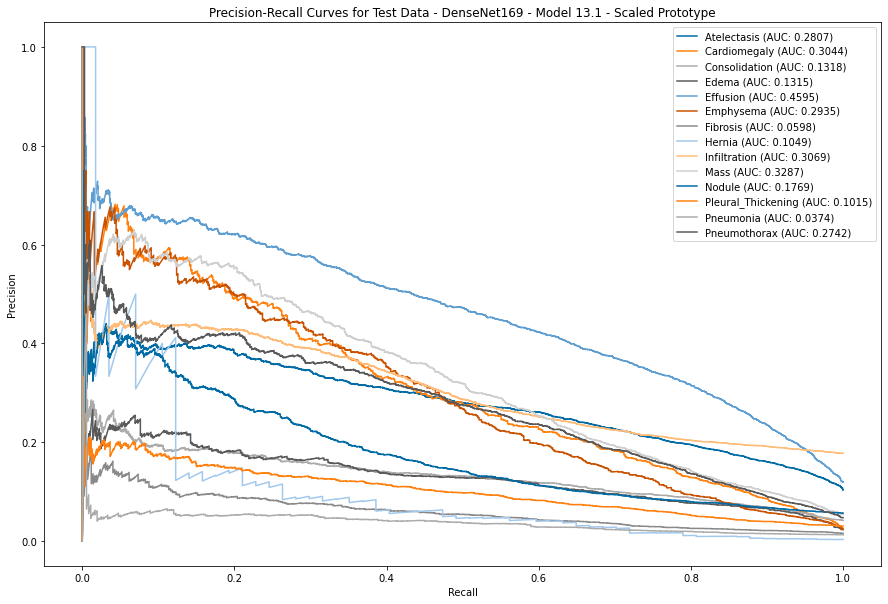

In [25]:
plot_precision_recall_auc(y_pred_dn, test_df, labels, model_name='DenseNet169 - Model 13.1 - Scaled Prototype')

# Deployment Threshold

In [26]:
import copy

def prob2class(y_pred, threshold):
    temp = copy.deepcopy(y_pred)
    temp[temp >= threshold] = 1
    temp[temp < threshold] = 0
    return temp

In [27]:
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score, confusion_matrix
#thresholds = [np.linspace(0.01, 0.99, 99)]
thresholds = [
    0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
    0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
    0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
    0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
    0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
    0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
    0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
    0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
    0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99
    ]

metrics_df = pd.DataFrame(columns=['threshold', 'accuracy', 'hamming_loss', 'precision', 'recall', 'f1'])
for threshold in thresholds:
    y_pred = prob2class(y_pred_dn, threshold)
    temp = pd.DataFrame({
        'threshold': [threshold],
        'accuracy': [accuracy_score(test_df[labels].to_numpy(), y_pred, normalize=True, sample_weight=None)],
        'hamming_loss': [hamming_loss(test_df[labels].to_numpy(), y_pred)],
        'precision': [precision_score(test_df[labels].to_numpy(), y_pred, average='samples')], 
        'recall': [recall_score(test_df[labels].to_numpy(), y_pred, average='samples')],
        'f1': [f1_score(test_df[labels].to_numpy(), y_pred, average='samples')]
    })
    metrics_df = pd.concat([metrics_df, temp])

metrics_df

threshold  accuracy  hamming_loss  precision    recall        f1
0        0.01  0.000000      0.906605   0.052904  0.458354  0.092699
0        0.02  0.000000      0.877641   0.053979  0.457495  0.094351
0        0.03  0.000000      0.851860   0.055026  0.456324  0.095908
0        0.04  0.000036      0.827557   0.056037  0.454914  0.097418
0        0.05  0.000143      0.804322   0.057012  0.452441  0.098794
..        ...       ...           ...        ...       ...       ...
0        0.95  0.520978      0.053173   0.042110  0.029489  0.032750
0        0.96  0.526329      0.052655   0.033072  0.022732  0.025428
0        0.97  0.532287      0.052166   0.024081  0.016323  0.018436
0        0.98  0.537852      0.051684   0.016393  0.011120  0.012570
0        0.99  0.540136      0.051631   0.007688  0.004989  0.005738

[99 rows x 6 columns]

In [28]:
np.linspace(0.01, 0.99, 99)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [29]:
# MacOS M1 Max round-off error while looping & using numpy:
for n in np.linspace(0.01, 0.99, 99):
    print(n) if n < 0.15 else ''

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14


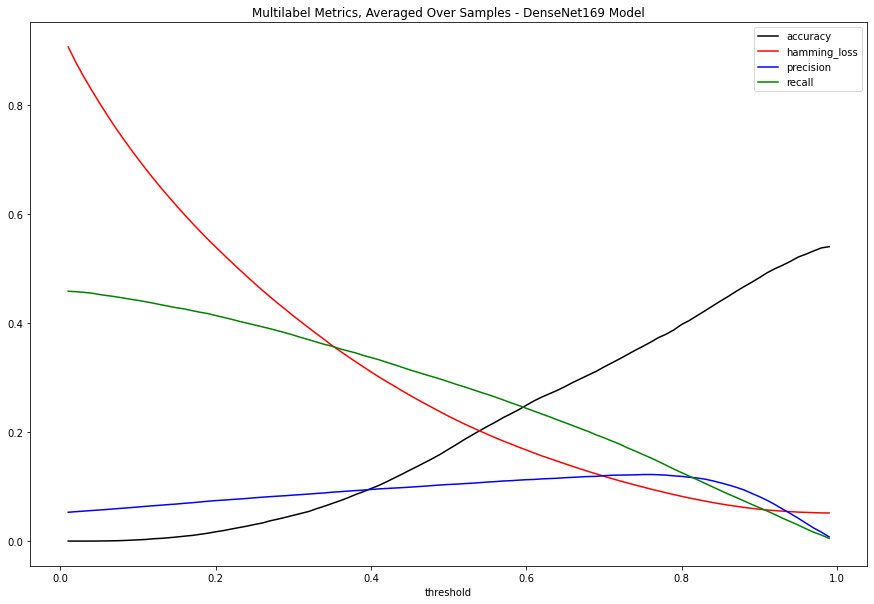

In [30]:
metrics_df.plot(
    kind='line', 
    x='threshold', 
    y=['accuracy', 'hamming_loss', 'precision', 'recall'], 
    color=['black', 'red', 'blue', 'green'], 
    figsize=(15, 10)
    )
ax = plt.gca()
ax.set_title('Multilabel Metrics, Averaged Over Samples - DenseNet169 Model');

In [31]:
# Calculate individual metrics for each label:
ind_metrics_df = pd.DataFrame(columns=['label', 'threshold', 'accuracy', 'precision', 'recall', 'f1'])
for i, lbl in enumerate(labels):
    for threshold in thresholds:
        y_pred = prob2class(y_pred_dn, threshold)
        tn, fp, fn, tp = confusion_matrix(test_df[lbl].to_numpy(), y_pred[:, i]).ravel()
        temp = pd.DataFrame({
            'label': [lbl],
            'threshold': [threshold],
            'accuracy': [accuracy_score(test_df[lbl].to_numpy(), y_pred[:, i])],
            'precision': [precision_score(test_df[lbl].to_numpy(), y_pred[:, i])], 
            'recall': [recall_score(test_df[lbl].to_numpy(), y_pred[:, i])],
            'f1': [f1_score(test_df[lbl].to_numpy(), y_pred[:, i])],
            'tn': [tn],
            'fp': [fp],
            'fn': [fn],
            'tp': [tp]
            })
        ind_metrics_df = pd.concat([ind_metrics_df, temp])

In [32]:
ind_metrics_df

label  threshold  accuracy  precision    recall        f1       tn  \
0    Atelectasis       0.01  0.105494   0.103322  0.999654  0.187287     68.0   
0    Atelectasis       0.02  0.116447   0.104441  0.999308  0.189117    376.0   
0    Atelectasis       0.03  0.131074   0.106013  0.999308  0.191690    786.0   
0    Atelectasis       0.04  0.148377   0.107846  0.998270  0.194663   1274.0   
0    Atelectasis       0.05  0.166536   0.109849  0.997232  0.197899   1786.0   
..           ...        ...       ...        ...       ...       ...      ...   
0   Pneumothorax       0.95  0.949483   0.421416  0.184151  0.256303  26370.0   
0   Pneumothorax       0.96  0.950161   0.412621  0.128302  0.195740  26463.0   
0   Pneumothorax       0.97  0.951338   0.415584  0.072453  0.123393  26570.0   
0   Pneumothorax       0.98  0.952729   0.500000  0.039245  0.072778  26653.0   
0   Pneumothorax       0.99  0.952872   0.583333  0.010566  0.020756  26695.0   

         fp      fn      tp  
0   25072.0     1.0  2889.0  
0   24764.0     2.0  2888.0  
0   24354.0     2.0  2888.0  
0   23866.0     5.0  2885.0  
0   23354.0     8.0  2882.0  
..      ...     ...     ...  
0     335.0  1081.0   244.0  
0     242.0  1155.0   170.0  
0     135.0  1229.0    96.0  
0      52.0  1273.0    52.0  
0      10.0  1311.0    14.0  

[1386 rows x 10 columns]

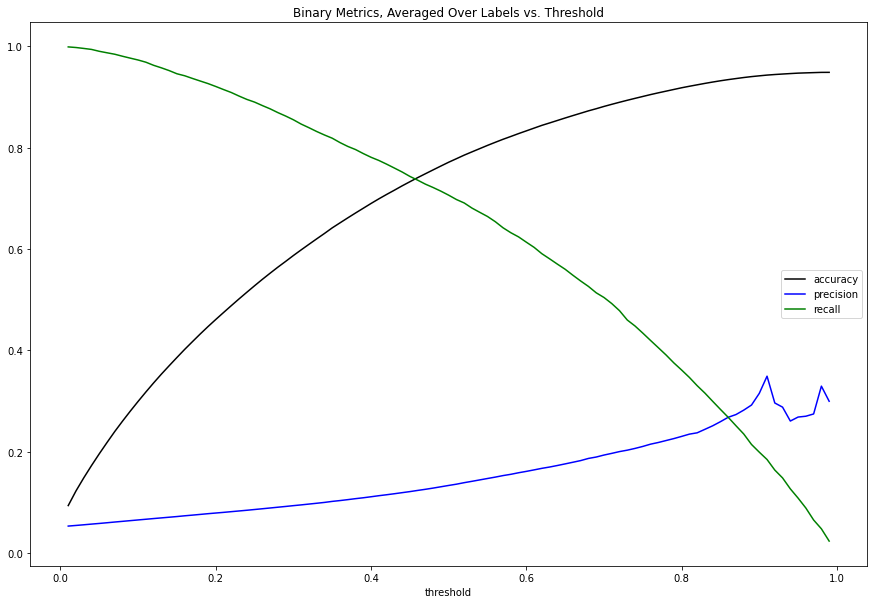

In [33]:
ind_metrics_df[['threshold', 'accuracy', 'precision', 'recall']].groupby('threshold').agg('mean').plot(kind='line', color=['black', 'blue', 'green'], figsize=(15, 10))
ax = plt.gca()
ax.set_title('Binary Metrics, Averaged Over Labels vs. Threshold');

In [34]:
ind_metrics_df[ind_metrics_df.threshold == 0.5].groupby('threshold').agg('mean')


accuracy  precision    recall        f1            tn           fp  \
threshold                                                                       
0.5        0.771018   0.133101  0.705939  0.206552  20654.785714  5925.642857   

                   fn          tp  
threshold                          
0.5        492.714286  956.857143

In [35]:
ind_metrics_df[ind_metrics_df.threshold == 0.75].groupby('threshold').agg('mean')

accuracy  precision    recall        f1            tn           fp  \
threshold                                                                       
0.75       0.900775   0.210107  0.433749  0.236705  24725.857143  1854.571429   

                   fn          tp  
threshold                          
0.75       926.714286  522.857143

# Conclusions
- The plots in the previous section were generated to assist in picking at threshold for a deployment model, though it should be noted that picking a threshold is highly dependent on domain knowledge and the specific use-case of the algorithm. 
<br>
<br>
- For example, picking a threshold = 0.5 results in a sensitivity / recall of \~70%, which means the model is able to accurately capture 70% of cases where disease is present. However, this is at the cost of a Precision of \~13%, which means that out of all the times the model is predicting a positive case, it's right about ~13% of the time (large amount of false positives, which might be OK if this model is used as a preliminary screen & in conjunction with a professional radiologist).
<br>
<br>
- If the threshold is increased to 0.75, precision increases to 21%, but recall drops to 43% (an example of precision-recall trade-off). 
<br>
<br>
- Since this is a multilabel problem (each label has its own probability), one could also leverage domain knowledge to select different thresholds for different diseases (e.g. certain diseases are more severe than others, thus, would probably want the model to be more sensitive for that specific disease)
<br>
<br>
- For the purposes of this capstone project, a threshold = 0.5 will be chosen (arbitrarily, as threshold selection is domain-specific and I do not have experience in the medical field).

In [36]:
metrics_df[metrics_df.threshold == 0.5]

threshold  accuracy  hamming_loss  precision    recall       f1
0        0.5  0.168712      0.228982    0.10391  0.292228  0.14124

In [37]:
ind_metrics_df[ind_metrics_df.threshold == 0.5]

label  threshold  accuracy  precision    recall        f1  \
0         Atelectasis        0.5  0.706172   0.219164  0.721799  0.336235   
0        Cardiomegaly        0.5  0.796932   0.097844  0.876081  0.176028   
0       Consolidation        0.5  0.732215   0.101471  0.691517  0.176974   
0               Edema        0.5  0.821263   0.082643  0.762153  0.149117   
0            Effusion        0.5  0.760756   0.307666  0.811355  0.446151   
0           Emphysema        0.5  0.766357   0.076659  0.852146  0.140664   
0            Fibrosis        0.5  0.759686   0.040064  0.651659  0.075487   
0              Hernia        0.5  0.789119   0.008398  0.877193  0.016636   
0        Infiltration        0.5  0.702533   0.294692  0.485622  0.366798   
0                Mass        0.5  0.873778   0.232421  0.629066  0.339432   
0              Nodule        0.5  0.815912   0.148141  0.475679  0.225923   
0  Pleural_Thickening        0.5  0.713949   0.069508  0.684397  0.126199   
0           Pneumonia        0.5  0.770103   0.032422  0.589385  0.061462   
0        Pneumothorax        0.5  0.785480   0.152329  0.775094  0.254618   

        tn      fp      fn      tp  
0  17708.0  7432.0   804.0  2086.0  
0  21730.0  5606.0    86.0   608.0  
0  19717.0  7146.0   360.0   807.0  
0  22581.0  4873.0   137.0   439.0  
0  18623.0  6078.0   628.0  2701.0  
0  20945.0  6456.0    93.0   536.0  
0  21019.0  6589.0   147.0   275.0  
0  22069.0  5904.0     7.0    50.0  
0  17277.0  5780.0  2558.0  2415.0  
0  23583.0  3002.0   536.0   909.0  
0  22117.0  4330.0   830.0   753.0  
0  19433.0  7751.0   267.0   579.0  
0  21375.0  6297.0   147.0   211.0  
0  20990.0  5715.0   298.0  1027.0

In [38]:
model_dense169.save('./Deployment/ucsd-mle-dl-prototype')

2022-03-08 19:30:12.524066: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Deployment/ucsd-mle-dl-prototype/assets
